In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re

In [3]:
MEAN_MAX_PATTERN = r'mean=(\d+\.?\d*) max=(\d+\.?\d*)'

profile_stats = ['mean', 'max']

features = ['cpu', 'mem' ]#'disk', 'tmp']
feature_units = ['', '[MBK]iB', '[MBK]', '[MBK]']

feature_patterns = {}
for feature, unit in zip(features, feature_units):
    suffix = ' '.join(f'{stat}=(\d+\.?\d*{unit})' for stat in profile_stats)
    pattern = f'{feature} {suffix}'
    feature_patterns[feature] = pattern

time_pattern = 'time=(\d+)m(\d+)s'
feature_patterns['time'] = time_pattern
# prefix_patterns = {prefix: prefix + ' ' + MEAN_MAX_PATTERN 
#                    for feature, unit in zip(features, feature_units)}
# prefix_patterns['mem'] = r'mem mean=(\d+\.\d+)[MBK]iB max=(\d+\.\d+)[MBK]iB'
feature_patterns

{'cpu': 'cpu mean=(\\d+\\.?\\d*) max=(\\d+\\.?\\d*)',
 'mem': 'mem mean=(\\d+\\.?\\d*[MBK]iB) max=(\\d+\\.?\\d*[MBK]iB)',
 'time': 'time=(\\d+)m(\\d+)s'}

In [4]:
time_pattern = 'time=(\d+)m(\d+)s'

In [5]:
feature_stats = {'cpu': ('mean', "max"), "mem": ("mean", "max"), 'time': ("time")}

In [6]:
import bitmath


data = []
 
def add_data(sample_id, feature, stat, value):
    value = float(value)
    d = dict(sample_id=sample_id, feature=feature, stat=stat, value=value)
    data.append(d)
    
    
def parse_values(found):
    """Convert string values into addable floats"""
    try:
        # Simple conversion to floats - no other strings
        found = [float(x) for x in found[0]]
    except ValueError:
        # There's letters in here specifying the unit
        found = [bitmath.parse_string(x).to_MiB() for x in found[0]]
    return found


# def maybe_add_data_from_line()


for filename in glob.iglob('../sourmash/maca/facs_compute_v7_all/log*'):
    basename = os.path.basename(filename)
    sample_id = basename.split('log.')[-1]
    with open(filename) as f:
        for line in f:
            for feature, pattern in feature_patterns.items():
                found = re.findall(pattern, line)
                if len(found) > 0:
                    
                    stats = feature_stats[feature]
                    
                    found = parse_values(found)
                        
                    if feature == 'time':
                        stat = 'seconds'
                        # first field is minutes, second is seconds. save total seconds
                        value = found[0]*60 + found[1]
                        add_data(sample_id, feature, stat, value)
                        continue
                    
                    for stat, value in zip(stats, found):
                        add_data(sample_id, feature, stat, value)


profile = pd.DataFrame(data)
# profile['value'] = profile['value'].astype(float)
print(profile.shape)
profile.head()

(730438, 4)


,feature,sample_id,stat,value
0,cpu,P11-B001717-3_38_F-1-1,mean,0.9
1,cpu,P11-B001717-3_38_F-1-1,max,1.0
2,cpu,P11-B001717-3_38_F-1-1,mean,0.9
3,cpu,P11-B001717-3_38_F-1-1,max,1.0
4,cpu,P11-B001717-3_38_F-1-1,mean,1.0


In [18]:
import s3_utils

In [19]:
s3_utils.write_s3(profile, 's3://olgabot-maca/facs/sourmash_compute_cpu_mem_time_profile.csv', 'csv')

In [7]:
profile.groupby(['feature', 'stat']).describe()

value                                                     \
                    count        mean         std   min    25%    50%    75%   
feature stat                                                                   
cpu     max      220980.0    0.900326    0.974888   0.0    1.0    1.0    1.0   
        mean     220980.0    0.859620    0.927424   0.0    0.7    1.0    1.0   
mem     max      100063.0   22.887398   50.931460   1.5   18.0   18.5   19.5   
        mean     100063.0   20.528520   42.435238   1.5   17.5   17.8   18.2   
time    seconds   88352.0  329.783468  204.873663  60.0  187.0  283.0  434.0   

                         
                    max  
feature stat             
cpu     max        10.1  
        mean        7.9  
mem     max      1021.4  
        mean     1021.4  
time    seconds  3278.0

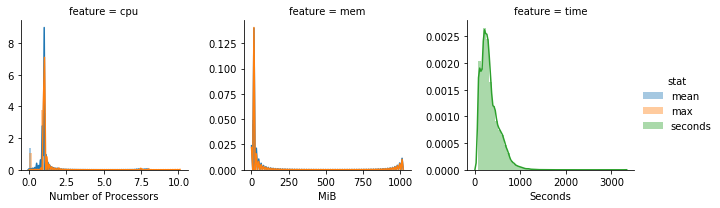

In [8]:
import seaborn as sns

g = sns.FacetGrid(profile, col='feature', hue='stat', 
                  sharex=False, sharey=False, col_wrap=3)
g.map(sns.distplot, 'value')
for ax in g.axes.flat:
    if 'time' in ax.get_title():
        xlabel = 'Seconds'
    elif 'mem' in ax.get_title():
        xlabel = 'MiB'
    else:
        xlabel = 'Number of Processors'
    ax.set(xlabel=xlabel)
g.add_legend()

Disk and tmp are zero for everything - remove

In [9]:
disk_tmp = "disk", "tmp"

profile_not_disk_tmp = profile.query("feature not in @disk_tmp")
profile_not_disk_tmp.head()

,feature,sample_id,stat,value
0,cpu,P11-B001717-3_38_F-1-1,mean,0.9
1,cpu,P11-B001717-3_38_F-1-1,max,1.0
2,cpu,P11-B001717-3_38_F-1-1,mean,0.9
3,cpu,P11-B001717-3_38_F-1-1,max,1.0
4,cpu,P11-B001717-3_38_F-1-1,mean,1.0


In [10]:
profile_time = profile_not_disk_tmp.query("feature == 'time'")
profile_time.head()

,feature,sample_id,stat,value
8,time,P11-B001717-3_38_F-1-1,seconds,499.0
15,time,P19-MAA000556-3_9_M-1-1,seconds,193.0
28,time,C22-MAA000400-3_8_M-1-1,seconds,324.0
35,time,P6-D042186-3_8_M-1-1,seconds,233.0
58,time,G5-MAA000600-3_8_M-1-1,seconds,481.0


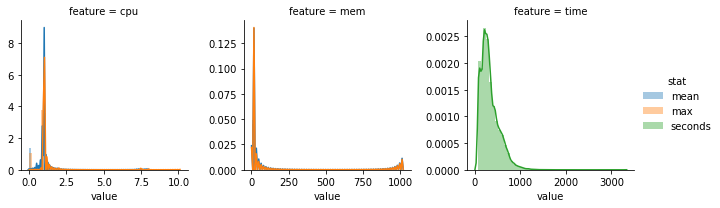

In [11]:
import seaborn as sns

g = sns.FacetGrid(profile_not_disk_tmp, col='feature', hue='stat', 
                  sharex=False, sharey=False, col_wrap=3)
g.map(sns.distplot, 'value')
g.add_legend()

In [12]:
mem_cpu = "mem", "cpu"

profile_mem_cpu = profile.query("feature in @mem_cpu")
profile_mem_cpu.head()

,feature,sample_id,stat,value
0,cpu,P11-B001717-3_38_F-1-1,mean,0.9
1,cpu,P11-B001717-3_38_F-1-1,max,1.0
2,cpu,P11-B001717-3_38_F-1-1,mean,0.9
3,cpu,P11-B001717-3_38_F-1-1,max,1.0
4,cpu,P11-B001717-3_38_F-1-1,mean,1.0


In [13]:
profile_mem_cpu.groupby(['feature', 'stat']).describe()

value                                                     
                 count       mean        std  min   25%   50%   75%     max
feature stat                                                               
cpu     max   220980.0   0.900326   0.974888  0.0   1.0   1.0   1.0    10.1
        mean  220980.0   0.859620   0.927424  0.0   0.7   1.0   1.0     7.9
mem     max   100063.0  22.887398  50.931460  1.5  18.0  18.5  19.5  1021.4
        mean  100063.0  20.528520  42.435238  1.5  17.5  17.8  18.2  1021.4

/home/olga/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


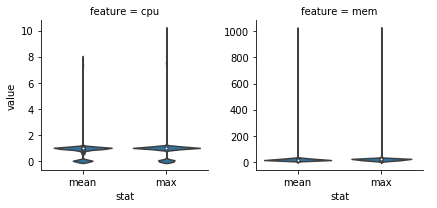

In [14]:
g = sns.FacetGrid(profile_mem_cpu, col='feature', sharex=False, sharey=False)
g.map(sns.violinplot, 'stat', 'value', split=True)
g.add_legend()

In [15]:
# sns.set(style='white')

NameError: name 'fig' is not defined

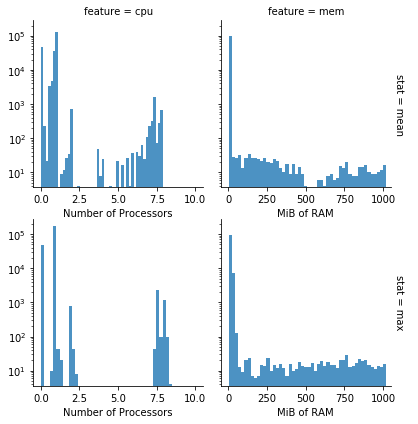

In [16]:
g = sns.FacetGrid(profile_mem_cpu, col='feature', row='stat', sharex=False,
                  sharey=True, margin_titles=True)
g.map(sns.distplot, 'value', kde=False, hist_kws=dict(alpha=0.8))
g.add_legend()

for ax in g.axes.flat:
    ax.set_yscale('log')
    if ax.is_first_col():
        xlabel = 'Number of Processors'
        xlim = (-0.5, 10.5)
    else:
        xlabel = 'MiB of RAM'
        xlim = (-50, 1050)
    ax.set(xlim=xlim, xlabel=xlabel)
fig.savefig('../figures/minhash_compute_time.pdf')

In [ ]:
profile_time['minutes'] = profile_time['value']/60
profile_time.head()

In [ ]:
mkdir ../figures/

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.distplot(profile_time['minutes'], kde=False, hist_kws=dict(alpha=0.8))
sns.despine()
ax.set(title='MinHash compute time\nk=21,27,33,51; DNA and protein signatures', ylabel='cells');
fig.tight_layout()
fig.savefig('../figures/minhash_compute_time.pdf')